In [2]:
import nbdHelp as ndb
import ndbDELETE as ndb2
from functools import partial

import os
import glob
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import scipy.ndimage
from scipy.spatial import Voronoi, voronoi_plot_2d

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

import math
from collections import defaultdict
import numpy as np

import io
import base64
from IPython.display import HTML, display
import matplotlib.pyplot as plt

rc('animation', html='jshtml')


In [3]:
in_path = '/Users/ameyavelankar/Library/CloudStorage/OneDrive-UW/Writing/NFLBIGDATA/data/processed/df_in.parquet'
out_path = '/Users/ameyavelankar/Library/CloudStorage/OneDrive-UW/Writing/NFLBIGDATA/data/processed/df_out.parquet'
sup_path = '/Users/ameyavelankar/Library/CloudStorage/OneDrive-UW/Writing/NFLBIGDATA/data/processed/sup_file.parquet'

df_in = pd.read_parquet(in_path)
df_out = pd.read_parquet(out_path)
sup_file = pd.read_parquet(sup_path)
map_file= pd.read_parquet('/Users/ameyavelankar/Library/CloudStorage/OneDrive-UW/Writing/NFLBIGDATA/data/processed/mapping_df.parquet')

print('Loaded df_in:', df_in.shape)
print('Loaded df_out:', df_out.shape)
print('Loaded sup_file:', sup_file.shape)
print('Loaded map_file:', map_file.shape)

Loaded df_in: (4880579, 24)
Loaded df_out: (562936, 7)
Loaded sup_file: (18009, 42)
Loaded map_file: (14108, 5)


In [4]:
# Merge df_out with df_in to get player_role for each row
df_out_merged = df_out.merge(df_in[['game_id', 'play_id', 'nfl_id', 'frame_id', 'player_role']],
                      on=['game_id', 'play_id', 'nfl_id', 'frame_id'],
                      how='left')

In [5]:
# get array of all flat_play_ids (from mapping dataframe)
flat_play_ids = np.sort(map_file['flat_play_id'].unique())
print(len(flat_play_ids))
print(flat_play_ids[:-10])

14108
[    0     1     2 ... 14095 14096 14097]


In [6]:
def prep_for_heat(id, df=None, n=2, angle_unit='rad'):
    """
    Prepare receiver + defender final positions and velocities for a heatmap.

    Inputs:
      - id: play id 
      - df: optional DataFrame; if provided, the function calls
            ndb.get_last_n_frames_coords(id_or_coords, df, n=n)
      - n: number of frames to request when calling get_last_n_frames_coords (default 2)
      - angle_unit: 'deg' (default) or 'rad' for velocity direction units.

    Returns:
      (receiver_final_x, receiver_final_y, receiver_final_v_mag, receiver_final_v_dir),
      defender_positions,   # tuple of (x,y) tuples: ((d1x,d1y),(d2x,d2y),...)
      defender_v_mags,      # tuple of mags: (d1_mag, d2_mag, ...)
      defender_v_dirs       # tuple of directions: (d1_dir, d2_dir, ...)

    Notes / assumptions:
      - get_last_n_frames_coords returns a flat list: (nfl_id, frame_id, x, y, player_role)
      - Velocities are computed from the last two frames for each player (if available).
      - If only one frame exists for a player, v_mag = 0 and v_dir = np.nan.
      - Receiver is detected by player_role starting with 'r' (case-insensitive) or containing 'receiver'.
      - Players whose role contains 'ball' or 'football' are ignored.
    """
    

    
    coords = ndb.get_last_n_frames_coords(id, df, n=n)
    
    # Expect coords: list of (nfl_id, frame_id, x, y, player_role)
    # Group by nfl_id, keep tuples of (frame_id, x, y, role)
    players = defaultdict(list)
    for item in coords:
        try:
            nfl_id, frame_id, x, y, role = item
        except Exception:
            # skip malformed entries
            continue
        players[nfl_id].append((frame_id, float(x), float(y), str(role)))

    # Sort each player's frames by frame_id ascending
    for pid in list(players.keys()):
        players[pid].sort(key=lambda t: t[0])

    # Helper to compute velocity from last two frames (or return 0, nan)
    def compute_vel(frames):
        # frames: list of (frame_id, x, y, role) sorted by frame_id asc
        if len(frames) >= 2:
            _, x1, y1, _ = frames[-2]
            _, x2, y2, _ = frames[-1]
            dx = x2 - x1
            dy = y2 - y1
            mag = np.clip(float(math.hypot(dx, dy))*10,0,10.5)
            ang = float(math.atan2(dy, dx))
            if angle_unit == 'deg':
                ang = math.degrees(ang)
            return mag, ang
        else:
            return 0.0, float('nan')

    # Identify receiver: prefer a player whose most-recent role startswith 'r' or contains 'receiver'.
    receiver_pid = None
    receiver_candidate_frame = -1
    for pid, frames in players.items():
        last_role = frames[-1][3].lower() if frames and frames[-1][3] is not None else ''
        if last_role.startswith('r') or 'receiver' in last_role or 'target' in last_role:
            # choose the candidate with the most recent frame (highest frame id)
            last_frame_id = frames[-1][0]
            if last_frame_id >= receiver_candidate_frame:
                receiver_candidate_frame = last_frame_id
                receiver_pid = pid

    # If none found, try to find a player named 'receiver' anywhere in role strings
    if receiver_pid is None:
        for pid, frames in players.items():
            last_role = frames[-1][3].lower() if frames and frames[-1][3] is not None else ''
            if 'receiver' in last_role:
                receiver_pid = pid
                break

    # Prepare receiver outputs
    if receiver_pid is not None:
        rframes = players[receiver_pid]
        recv_x = float(rframes[-1][1])
        recv_y = float(rframes[-1][2])
        recv_v_mag, recv_v_dir = compute_vel(rframes)
    else:
        # fallback: return NaNs if no receiver detected
        recv_x = float('nan')
        recv_y = float('nan')
        recv_v_mag = 0.0
        recv_v_dir = float('nan')

    # Prepare defender lists: exclude receiver and any 'ball'/'football' roles
    defender_positions = []
    defender_v_mags = []
    defender_v_dirs = []

    for pid in sorted(players.keys()):
        if pid == receiver_pid:
            continue
        frames = players[pid]
        # ignore ball/football if role indicates that
        last_role = frames[-1][3].lower() if frames and frames[-1][3] is not None else ''
        if 'ball' in last_role or 'football' in last_role:
            continue
        # final position
        fx = float(frames[-1][1])
        fy = float(frames[-1][2])
        fmag, fdir = compute_vel(frames)
        defender_positions.append((fx, fy))
        defender_v_mags.append(fmag)
        defender_v_dirs.append(fdir)

    # Convert lists to tuples as requested
    defender_positions = tuple(defender_positions)
    defender_v_mags = tuple(defender_v_mags)
    defender_v_dirs = tuple(defender_v_dirs)

    return (recv_x, recv_y, float(recv_v_mag), float(recv_v_dir)), defender_positions, defender_v_mags, defender_v_dirs

def center_coordinates(rec_info,def_pos):
    rx,ry,_,_=rec_info
    centered_def_pos = []
    for (dx,dy) in def_pos:
        centered_def_pos.append( (dx - rx, dy - ry) )
    return centered_def_pos



In [7]:
def get_voronoi(id,return_data=True):    
    rec_info,def_pos,def_vs,def_vts=prep_for_heat(id,df=df_out_merged,n=2)
    #print('Receiver info (x,y,v_mag,v_dir):', rec_info)
    #print('Defender positions (x,y):', def_pos)
    #print('Defender v_mags:', def_vs)
    #print('Defender v_dirs:', def_vts)
    centered_def_pos = center_coordinates(rec_info,def_pos)
    #print('Centered defender positions (x,y):', centered_def_pos)
    # Call the multi-point plot with the list of fns

    pos1 = (0,0)
    v1=rec_info[2]
    v1t=rec_info[3]
    pos2_list = centered_def_pos
    v2_list=def_vs
    v2t_list=def_vts
    sideline_dist=abs(rec_info[1])
    from functools import partial

    # P1 function
    time_fn_p1 = partial(ndb.optimized_physics_time_wrapper,vi=v1,vt=v1t,astop=12,ago=8,aturnmax=7,vmax=10.5)

    # Make one function per P2 player (bind each player's v and vt)
    time_fn_p2_list = [
        partial(ndb.optimized_physics_time_wrapper,vi=v,vt=vt,astop=12,ago=8,aturnmax=7,vmax=10.5)
        for v, vt in zip(v2_list, v2t_list)
    ]
    
# Call the multi-point plot with the list of fns
    fig, ax, XX, YY, TT1, TT_others, combined = ndb.plot_multi_point_control_map(
        time_fn_p1,
        time_fn_p2_list,
        pos1=pos1,
        pos2_list=pos2_list,
        sideline_dist=sideline_dist,
        vel1=v1t,
        vel2_list=v2t_list,
        combine_fn=ndb.soft_ownership(beta=1),
        xlim=(-1.5, 1.5),
        ylim=(-1.5, 1.5),
        resolution=0.05,
        cmap='grey',
        show_time_contours=False,
        show_vel_direc=True,
        show_people=False,
        gauss_Filter=None,
        arrow_len=1.0
    )
    if return_data:
        plt.close(fig)
        return XX, YY, combined
    #print(combined.shape)
    plt.close(fig)
    return fig,ax



(5:49) (Shotgun) T.Taylor pass short right to W.Robinson pushed ob at PHI 3 for 19 yards (K.Byard).
          game_id  season  week   game_date game_time_eastern home_team_abbr  \
13947  2024010711    2023    18  01/07/2024          16:25:00            NYG   

      visitor_team_abbr  play_id  \
13947               PHI     1562   

                                        play_description  quarter  ...  \
13947  (5:49) (Shotgun) T.Taylor pass short right to ...        2  ...   

      penalty_yards  pre_penalty_yards_gained  yards_gained expected_points  \
13947           NaN                        19            19        4.572543   

      expected_points_added pre_snap_home_team_win_probability  \
13947              1.647063                           0.845877   

       pre_snap_visitor_team_win_probability  home_team_win_probability_added  \
13947                               0.154123                         0.018932   

       visitor_team_win_probility_added flat_play_id  
13947  


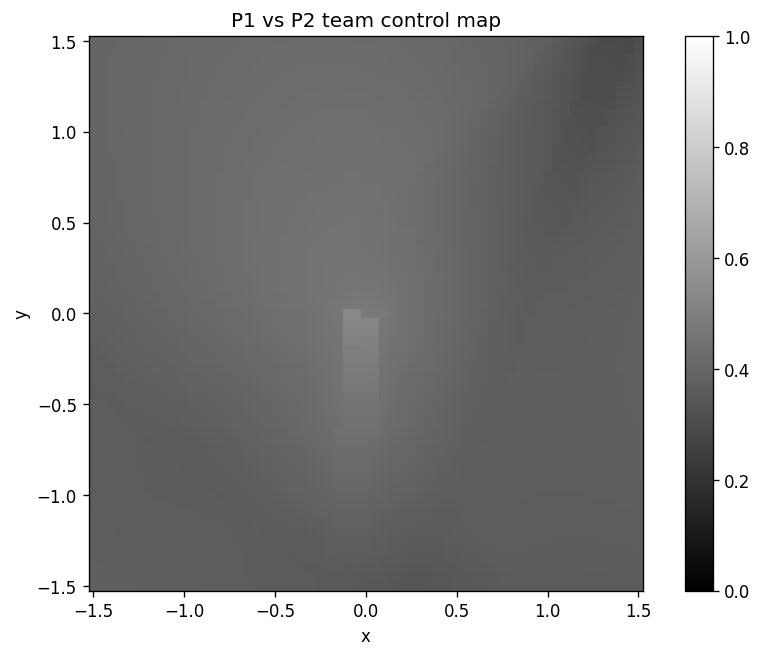

In [9]:
id=13975
fig,ax=get_voronoi(id,return_data=False)
anim=ndb2.animate_play_flat(flat_play_id=id, df_in=df_in, df_out=df_out, mapping_df=map_file,sup_file=sup_file,full_info=True,half_info=False)
ndb2.display_fig_anim_side_by_side(fig, anim, img_dpi=120, img_max_width='45%', anim_scale=1.5, close_fig=True)

In [10]:
import shutil
from PIL import Image

def save_field_grayscale_png(combined, out_path="control_map_gray.png"):
    data = np.array(combined, dtype=float)

    # Check for NaNs before filling them
    if np.isnan(data).any():
        print("HI")

    # Replace NaN/±inf with 0 and clamp to [0,1]
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
    data = np.clip(data, 0.0, 1.0)

    # Scale to 8-bit and save
    arr8 = np.round(data * 255).astype(np.uint8)

    arr8 = arr8[::-1, :]
    
    Image.fromarray(arr8, mode="L").save(out_path)

def create_database(ids,delete=False):

    folder_loc='/Users/ameyavelankar/Library/CloudStorage/OneDrive-UW/Writing/NFLBIGDATA/data/processed/CSD_database_2/'
    if not os.path.exists(folder_loc):
        os.makedirs(folder_loc)
    if os.path.exists(folder_loc) and delete:
        shutil.rmtree(folder_loc)
        os.makedirs(folder_loc)

    for id in tqdm(ids):
        rec_info,def_pos,def_vs,def_vts=prep_for_heat(id,df=df_out_merged,n=2)
        centered_def_pos = center_coordinates(rec_info,def_pos)
    
        XX,YY,combined=get_voronoi(id,return_data=True)
        save_field_grayscale_png(combined, out_path=folder_loc+f'_{id}.png')
        


In [ ]:
#MAKE SURE.   PEOPLE AREN"T PLOTTED
#create_database(flat_play_ids,delete=False)

  0%|          | 0/14108 [00:00<?, ?it/s]

/Users/ameyavelankar/Library/CloudStorage/OneDrive-UW/Writing/NFLBIGDATA/WriteupPlots/nbdHelp.py:273: RuntimeWarning: invalid value encountered in scalar divide
  t2= r*phi1/vturn


-0.6999999999999993 -0.8499999999999994 6.706713054842833 -1.526050095340279
Error in optimization
